#### libics: drivers

# VRmagic VRmC-X

Product homepage: [Imaging USB Platform](https://www.vrmagic.com/imaging/service/downloads/usb-platform-downloads)

### Imports

In [1]:
from libics.drv import drv
from libics.drv.itf import itf

### Configuration

In [2]:
# Ethernet interface
itf_cfg = {
    "protocol": itf.ITF_PROTOCOL.TEXT,
    "interface": itf.ITF_TXT.ETHERNET,
    "address": "130.183.96.234",
    "buffer_size": 1024,
    "send_timeout": 1.0,
    "send_termchar": "\r\n",
    "recv_timeout": 1.0,
    "recv_termchar": "\r\n",
    "txt_ethernet_type": itf.TXT_ETHERNET_TYPE.GENERIC,
    "port": 23,
    "blocking": True,
}
itf_cfg = itf.ProtocolCfgBase(**itf_cfg).get_hl_cfg()

In [3]:
# USB interface
itf_cfg = {
    "protocol": itf.ITF_PROTOCOL.TEXT,
    "interface": itf.ITF_TXT.USB,
    "buffer_size": 1024,
    "send_timeout": 1.0,
    "send_termchar": "\r\n",
    "recv_timeout": 1.0,
    "recv_termchar": "\r\n",
    "usb_vendor": 0x104d,
    "usb_product": 0x4000,
}
itf_cfg = itf.ProtocolCfgBase(**itf_cfg).get_hl_cfg()

In [4]:
drv_cfg = {
    "driver": drv.DRV_DRIVER.PICO,
    "interface": itf_cfg,
    "identifier": "66048",
    "model": drv.DRV_MODEL.NEWPORT_8742,
    "acceleration": 100000,
    "velocity": 1750,
    "channel": 1,
    "feedback_mode": drv.DRV_PICO.FEEDBACK_MODE.OPEN_LOOP
}
drv_cfg = drv.DrvCfgBase(**drv_cfg).get_hl_cfg()

### Setup

In [5]:
pico = drv.DrvBase(cfg=drv_cfg).get_drv()

### Script

##### Demo script

In [6]:
with pico:
    print("Reading configuration")
    pico.read_all()
    print("Starting position")
    _pos = pico.read_position()
    print("  {:d} steps".format(_pos))
    print("Move relative")
    pico.move_relative(1000)
    _pos = pico.read_position()
    print("  {:d} steps".format(_pos))
    print("Zero position")
    pico.zero_position()
    _pos = pico.read_position()
    print("  {:d} steps".format(_pos))
    print("Move back")
    pico.move_relative(-1000)
    _pos = pico.read_position()
    print("  {:d} steps".format(_pos))
    print("Scan slave devices")
    _dev = pico.scan_slave_devices()
    print(" ", _dev)
    print("Reading error")
    _err = pico.read_error()
    print(" ", _err)

Reading configuration
Starting position
  -1000 steps
Move relative
  0 steps
Zero position
  0 steps
Move back
  -1000 steps
Scan slave devices
  []
Reading error
  38, COMMAND PARAMETER MISSING


In [1]:
import libics.drv.itf.api.vrmusbcamapi as vrm
import ctypes as ct
import numpy as np
import matplotlib.pyplot as plt

Device 0 (8514133): free
Previous exposure time: 30.0 ms
New exposure time: 17.0 ms
pitch-width 2


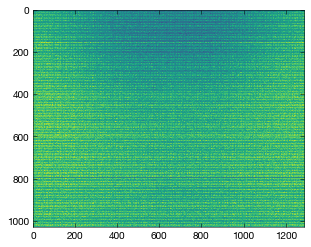

In [13]:
cam_id = 8514133

vrm.VRmUsbCamUpdateDeviceKeyList()

dev_count = vrm.VRmDWORD()
vrm.VRmUsbCamGetDeviceKeyListSize(ct.byref(dev_count))
dev_count = int(dev_count.value)

dev_key = None
dev_keys = [vrm.POINTER(vrm.VRmDeviceKey)() for _ in range(dev_count)]
[vrm.VRmUsbCamGetDeviceKeyListEntry(i, ct.byref(dev_key)) for i, dev_key in enumerate(dev_keys)]
for i, _dev_key in enumerate(dev_keys):
    print("Device {:d} ({:d}): {:s}".format(i, _dev_key.contents.m_serial, "busy" if _dev_key.contents.m_busy == 1 else "free"))
    if _dev_key.contents.m_serial == cam_id:
        dev_key = _dev_key
    else:
        vrm.VRmUsbCamFreeDeviceKey(_dev_key)

dev_handle = vrm.VRmUsbCamDevice()
vrm.VRmUsbCamOpenDevice(dev_key, ct.byref(dev_handle))

####################

src_fmt = vrm.VRM_GRAY_8
vrm.VRmUsbCamSetSourceFormatIndex(dev_handle, src_fmt)


propid = vrm.VRmPropId()
propinfo = vrm.VRmPropInfo()
prop_attr_b = vrm.VRmPropAttribsB()
prop_b = vrm.VRmBOOL()
prop_attr_d = vrm.VRmPropAttribsD()
prop_d = vrm.c_double()
prop_attr_i = vrm.VRmPropAttribsI()
prop_i = ct.c_int()
prop_attr_f = vrm.VRmPropAttribsF()
prop_f = ct.c_float()
prop_attr_e = vrm.VRmPropAttribsE()
prop_e = vrm.VRmPropId()
prop_attr_s = vrm.VRmPropAttribsS()
prop_s = ct.c_char_p()

vrm.VRmUsbCamGetPropertyValueF(dev_handle, vrm.VRM_PROPID_CAM_EXPOSURE_TIME_F, ct.byref(prop_f))
prop_exposure_time = prop_f.value
print("Previous exposure time: {:.1f} ms".format(prop_exposure_time))
prop_exposure_time = (prop_exposure_time + 27) % 20
prop_f.value = prop_exposure_time
vrm.VRmUsbCamSetPropertyValueF(dev_handle, vrm.VRM_PROPID_CAM_EXPOSURE_TIME_F, ct.byref(prop_f))
vrm.VRmUsbCamGetPropertyValueF(dev_handle, vrm.VRM_PROPID_CAM_EXPOSURE_TIME_F, ct.byref(prop_f))
prop_exposure_time = prop_f.value
print("New exposure time: {:.1f} ms".format(prop_exposure_time))

####################

vrm.VRmUsbCamStart(dev_handle)
frames_dropped = vrm.VRmBOOL()
img_ready = vrm.VRmBOOL()
img = vrm.POINTER(vrm.VRmImage)()
for ii in range(1):
    vrm.VRmUsbCamLockNextImage(dev_handle, ct.byref(img), ct.byref(frames_dropped))
    height = img.contents.m_image_format.m_height
    width = img.contents.m_image_format.m_width
    pitch = img.contents.m_pitch
    print('pitch-width %s' % (pitch-width))
    im = np.array(img.contents.mp_buffer[0:height * pitch]).reshape(height, pitch)
    
    vrm.VRmUsbCamUnlockNextImage(dev_handle, ct.byref(img))
r = vrm.VRmUsbCamStop(dev_handle)

####################

vrm.VRmUsbCamCloseDevice(dev_handle)
vrm.VRmUsbCamFreeDeviceKey(dev_key)


plt.imshow(im)

In [3]:
# update key list
r = vrm.VRmUsbCamUpdateDeviceKeyList()

# get number of devices
ndev = vrm.VRmDWORD()
r = vrm.VRmUsbCamGetDeviceKeyListSize(ct.byref(ndev))
print('Found %i cameras' % int(ndev.value))

# get a VRmDeviceKey
nodev = 1
devkey = vrm.POINTER(vrm.VRmDeviceKey)()
r = vrm.VRmUsbCamGetDeviceKeyListEntry(nodev - 1, ct.byref(devkey))
if r == 1:
    print('Busy? %i' % devkey.contents.m_busy)
    print('Serial %i' % devkey.contents.m_serial)
    print('Manufacturer %s' %
          devkey.contents.mp_manufacturer_str.data.decode('utf-8'))
    print('Product %s' % devkey.contents.mp_product_str.data.decode('utf-8'))

    # get a handle by opening a device
    if not devkey.contents.m_busy == 1:
        devhand = vrm.VRmUsbCamDevice()
        r = vrm.VRmUsbCamOpenDevice(devkey, ct.byref(devhand))
        print('Got handle? %i' % r)
    else:
        print('Camera busy!')

    # set format
    nsrcfmt = vrm.VRmDWORD()
    r = vrm.VRmUsbCamGetSourceFormatListSize(devhand, ct.byref(nsrcfmt))
    imagefmt = vrm.VRmImageFormat()  # The image format
    r = vrm.VRmUsbCamGetSourceFormatListEntry(devhand, nsrcfmt.value-1, ct.byref(imagefmt))
    r = vrm.VRmUsbCamSetSourceFormatIndex(devhand, nsrcfmt.value-1)

    # get number of sensor ports
    nports = vrm.VRmDWORD()
    r = vrm.VRmUsbCamGetSensorPortListSize(devhand, ct.byref(nports))
    print('Ports: %i' % nports.value)

    # configure
    # r = vrm.VRmUsbCamLoadConfig(devhand, 1)
    # print('Load config? %i' % r)

    # get all properties
    nprops = vrm.VRmDWORD()
    r = vrm.VRmUsbCamGetPropertyListSize(devhand, ct.byref(nprops))
    print('Number of properities: %i' % nprops.value)
    propid = vrm.VRmPropId()
    propinfo = vrm.VRmPropInfo()
    prop_attr_b = vrm.VRmPropAttribsB()
    prop_b = vrm.VRmBOOL()
    prop_attr_d = vrm.VRmPropAttribsD()
    prop_d = vrm.c_double()
    prop_attr_i = vrm.VRmPropAttribsI()
    prop_i = ct.c_int()
    prop_attr_f = vrm.VRmPropAttribsF()
    prop_f = ct.c_float()
    prop_attr_e = vrm.VRmPropAttribsE()
    prop_e = vrm.VRmPropId()
    prop_attr_s = vrm.VRmPropAttribsS()
    prop_s = ct.c_char_p()
    # set exposure time
    r = vrm.VRmUsbCamSetPropertyValueF(devhand, vrm.VRmPropId(4097), ct.byref(ct.c_float(1.0)))
    for ii in range(nprops.value):
        # for ii in range(1):
        r = vrm.VRmUsbCamGetPropertyListEntry(devhand, ii, ct.byref(propid))
        r = vrm.VRmUsbCamGetPropertyInfo(devhand, propid.value, ct.byref(propinfo))
        if propinfo.m_type == 1:
            r = vrm.VRmUsbCamGetPropertyAttribsB(devhand, propid.value, ct.byref(prop_attr_b))
            r = vrm.VRmUsbCamGetPropertyValueB(devhand, propid.value, ct.byref(prop_b))
            val = prop_b.value
        elif propinfo.m_type == 2:
            r = vrm.VRmUsbCamGetPropertyAttribsI(devhand, propid.value, ct.byref(prop_attr_i))
            r = vrm.VRmUsbCamGetPropertyValueI(devhand, propid.value, ct.byref(prop_i))
            val = prop_i.value
        elif propinfo.m_type == 3:
            r = vrm.VRmUsbCamGetPropertyAttribsF(devhand, propid.value, ct.byref(prop_attr_f))
            r = vrm.VRmUsbCamGetPropertyValueF(devhand, propid.value, ct.byref(prop_f))
            val = prop_f.value
        elif propinfo.m_type == 4:
            r = vrm.VRmUsbCamGetPropertyAttribsS(devhand, propid.value, ct.byref(prop_attr_s))
            r = vrm.VRmUsbCamGetPropertyValueS(devhand, propid.value, ct.byref(prop_s))
            val = prop_s.value
        elif propinfo.m_type == 5:
            r = vrm.VRmUsbCamGetPropertyAttribsE(devhand, propid.value, ct.byref(prop_attr_e))
            r = vrm.VRmUsbCamGetPropertyValueE(devhand, propid.value, ct.byref(prop_e))
            val = prop_e.value
        elif propinfo.m_type == 6:
            pass
        elif propinfo.m_type == 7:
            pass
        elif propinfo.m_type == 8:
            pass
        elif propinfo.m_type == 9:
            r = vrm.VRmUsbCamGetPropertyAttribsD(devhand, propid.value, ct.byref(prop_attr_d))
            r = vrm.VRmUsbCamGetPropertyValueD(devhand, propid.value, ct.byref(prop_d))
            val = prop_d.value
        if propinfo.m_writeable == 1:
            print('(W) Property %s has id %i, type %s and value %s' % (propinfo.m_description.data.decode('utf-8'), propinfo.m_id, propinfo.m_type, val))
        else:
            print('(R) Property %s has id %i, type %s and value %s' % (propinfo.m_description.data.decode('utf-8'), propinfo.m_id, propinfo.m_type, val))

    from time import sleep
    sleep(1)

    # start the camera frame grabber
    r = vrm.VRmUsbCamStart(devhand)
    framesdropped = vrm.VRmBOOL()
    imgready = vrm.VRmBOOL()
    image = vrm.POINTER(vrm.VRmImage)()
    print('Started? %i' % r)
    for ii in range(2):
        r = vrm.VRmUsbCamLockNextImage(devhand, ct.byref(image), ct.byref(framesdropped))
        print('Got image? %i' % r)
        if r == 1:
            height = image.contents.m_image_format.m_height
            width = image.contents.m_image_format.m_width
            pitch = image.contents.m_pitch
            print('pitch-width %s' % (pitch-width))
            im = np.array(image.contents.mp_buffer[0:height * pitch]).reshape(height, pitch)
        else:
            r = vrm.VRmUsbCamGetLastError()
            print(r.data.decode('utf-8'))
        r = vrm.VRmUsbCamUnlockNextImage(devhand, ct.byref(image))
        print('Unlocked image? %i' % r)
    # stop the camera frame grabber
    r = vrm.VRmUsbCamStop(devhand)
    print('Stopped? %i' % r)


    # close the device
    r = vrm.VRmUsbCamCloseDevice(devhand)
    print('Closed? %i' % r)

    # free device key
    r = vrm.VRmUsbCamFreeDeviceKey(ct.byref(devkey))
    print('Key free? %i' % r)

else:
    print('ERROR: Could not get key.')
    # get error
    r = vrm.VRmUsbCamGetLastError()
    print(r.data.decode('utf-8'))



Found 1 cameras
Busy? 0
Serial 8514133
Manufacturer VRmagic
Product VRmC-9+/BW
Got handle? 1
Ports: 1
Number of properities: 64
(W) Property Exposure Time [ms] has id 4097, type 3 and value 1.0
(R) Property Maximal Framerate (at current format, ignoring exposure time) [fps] has id 4106, type 3 and value 29.85757827758789
(R) Property Maximal acquisition rate (at current sensor configuration) [Hz] has id 4110, type 3 and value 7.464395523071289
(W) Property HBlank Duration [pixels] has id 4112, type 2 and value 19
(W) Property VBlank Duration [lines] has id 4113, type 2 and value 15
(R) Property Trigger/Expose Signal to Start of Exposure Delay [ms] has id 4114, type 3 and value 2.494499683380127
(R) Property Start of Exposure to VSync Delay [ms] has id 4116, type 3 and value 132.9466552734375
(R) Property Row Readout Time [ms] has id 4117, type 3 and value 0.1278333216905594
(W) Property Monochrome Gain has id 4131, type 2 and value 32
(R) Property Sensor Size has id 4160, type 6 and va